# Week 13 - Sequential Decision Making 2 (reinforcement learning)
## Monte Carlo predicition and control exercices

author: massimo.p.caccia@gmail.com <br>

The code was Adapted from: https://github.com/dennybritz/reinforcement-learning/tree/master/MC

## 1. Monte Carlo prediction

In these exercises, we will explore the **the Monte Carlo prediction algorithhm**. <br>

The algorithm is shown on [slide 13](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_rl2.pdf) of the slide deck. <br>
The algorithm will be tested on Blackjack (extra slide #32). <br>

### 1.1 Setup

In [1]:
# imports
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

First, we define the Blackjack environment, as seen on slide 32 and reproduced below. 

<ul>
<li />Black Jack is a card game where a player must obtain cards such that their sum is as close to 21 without exceeding it.
<li />Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11.
<li />In our example below, the player plays against a dealer. The dealer has a fixed policy of always asking for an additional card until the sum of their cards is above 17. 
<li /> Stationarity: This game is placed with an infinite deck (or with replacement).
</ul>

Game Process:
<ol>
<li /> The game starts with each (player and dealer) having one face up and one
    face down card.
<li /> The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
<li />If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
</ol>
<img src="blackjack.png" width="500">

In [2]:
env = BlackjackEnv()

### 1.2 Monte Carlo prediction

Recall that the Monte Carlo prediction algorithm provides a method for evaluating a given policy ($\pi$), that is obtain its value for each state $V(s)\;\;\forall s \in S$. 

It is similar to the policy evaluation step used in policy iteration for MDPs. The main difference is that **here we do not know the transition probabilities** and so we will have an agent that tries out the policy in the environment and, episode by episode, calculates the value function of the policy.

You need to write a function that evaluates the values of each states given a policy. <br>

The code below reproduces slide 13. <br>


In [3]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurence of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

Now, we will define a simple policy which we will evaluate. <br>
This policy is the same as the one presented is slide 16. <br>
Specifically, **the policy hits except when the sum of the card is 20 or 21.**

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

We now evaluate the policy for 20k iterations. <br>
The resulting figures should look like the ones in slide 16.

Episode 20000/20000.

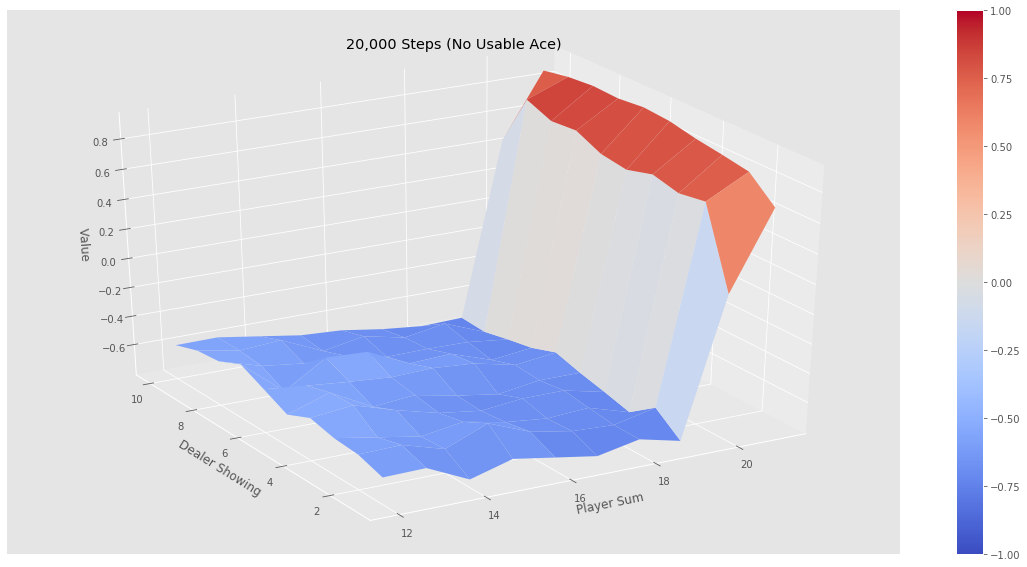

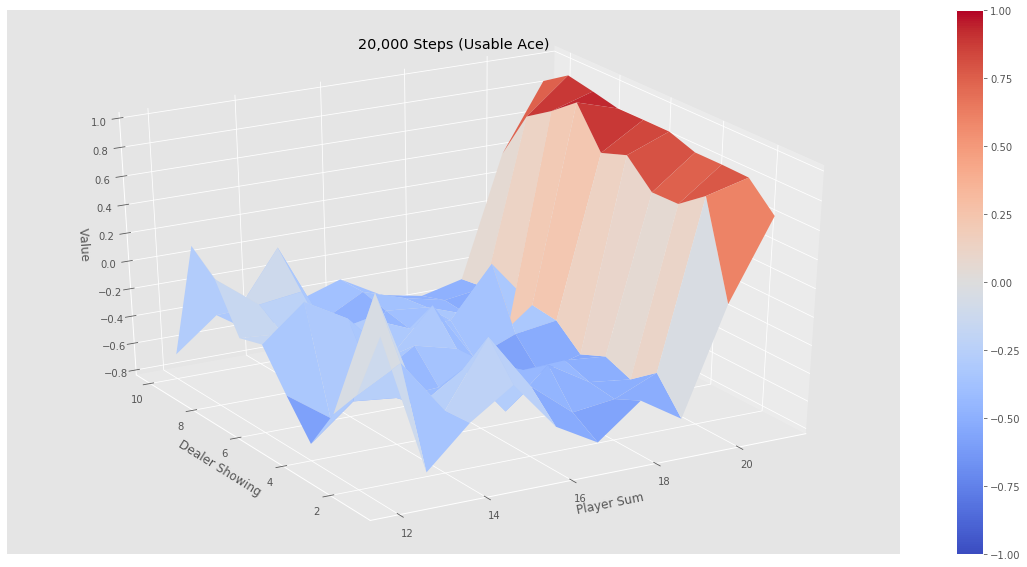

In [5]:
V_20k = mc_prediction(sample_policy, env, num_episodes=20000)
plotting.plot_value_function(V_20k, title="20,000 Steps")

### 1.3 Monte Carlo prediction excercice

What is the effect of the number of episodes (num_episodes) on the learned value function?
Before trying it, take a guess!

## 2. Monte Carlo control
Now, you will be tested on your capacity to **understand the Monte Carlo (on policy) control algortihm**. <br>
You can find details about the algorithm at slide 20 of the slide deck. <br>
The algorithm will be tested on Blackjack (extra slide #32) <br>

### 2.1 $\epsilon$-greedy policy

Before writing the reinforcement-learning algorithm, we need to have a $\epsilon$-greedy policy, a policy which takes a non-optimal action with a small percentage $\epsilon$. <br>

The motivation is presented in slide 19.

In [6]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

### 2.2 Monte Carlo control algorithm
Now here is the Monte Carlo Control algorithm. <br>
However, only make it run for `num_episodes`. <br>
and remember, the policy is improved implicitly by changing the Q function.

In [7]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
        
    
    return Q, policy

Let's train it for 100k episodes.

In [8]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=100000, epsilon=0.1)

Episode 100000/100000.

To make sure the Q function is sensible sensible, we will visually inspect it with a graph similar to the ones in slide 16. <br>


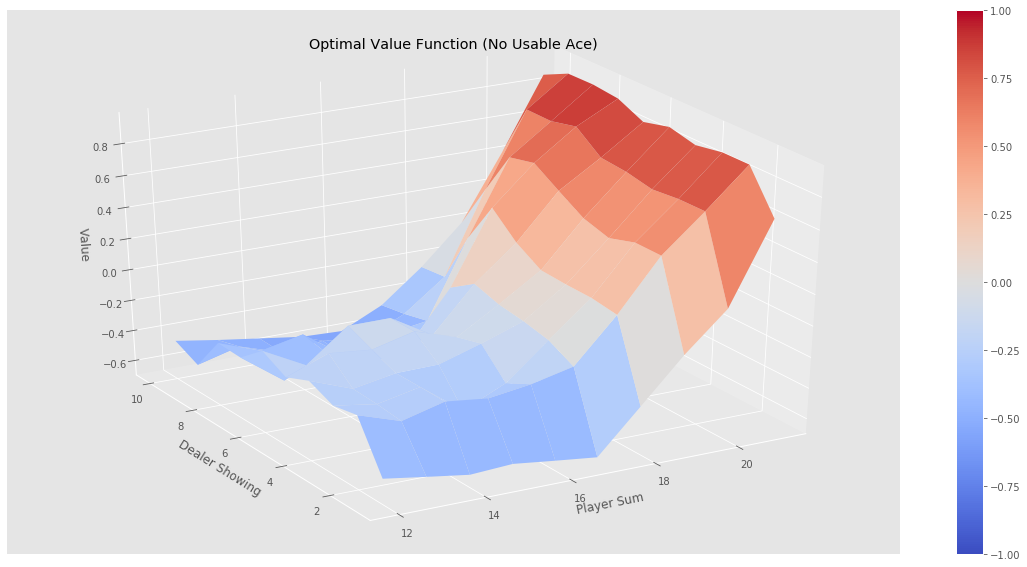

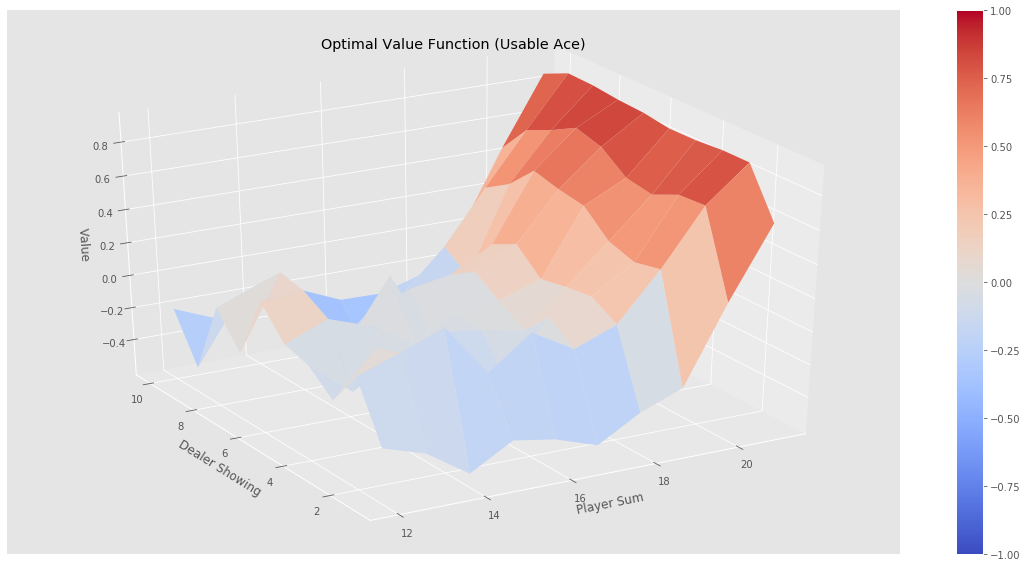

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

How does it compare with the evaluation of the simple policy we evaluated in 1.2? <br>
Does it reflect your intuition?

### 2.3 Monte Carlo control excercice
Again, what is the effect of the number of episodes (num_episodes) on the learned value function?